# Analysis

In [1]:
# Load Python Libraries
import json
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR

In [2]:
# Load external health data
df_external_data = pd.read_csv('../data/merged_data.csv', index_col=0)

# Load column descriptions
with open('../data/header_mapper.json') as json_file:
    header_mapper = json.load(json_file)

In [3]:
# Remove data after 2019 because of lack of samples
df_external_data = df_external_data[df_external_data.YEAR < 2019]

In [4]:
# Load Smoke Estimate
df_smoke = pd.read_csv('../data/impact_estimate.csv', index_col=0)
df_smoke = df_smoke.rename(columns={'Fire_Year': 'YEAR'})

In [5]:
# Drop unnecessary columns
df_smoke = df_smoke.drop(['Assigned_Fire_Type', 
               'GIS_Acres', 
               'Distance_To_County_miles', 
               'GIS_Acres_normalised', 
               'Distance_To_County_miles_normalised',
                'USGS_Assigned_ID'], axis=1)

In [6]:
# Aggregate yearly data
df_smoke = df_smoke.groupby('YEAR').sum()

In [7]:
# Merge the two dataframes
df_main = pd.merge(df_external_data, df_smoke, on='YEAR', how='inner')

In [8]:
df_main.head()

,val_deaths,val_incidence,YEAR,CDC20N2U004025,S1301_C04_001E,S1301_C04_001M,impact_estimate
0,2.223420,1404.898804,1990,NaN,NaN,NaN,972.152697
1,2.251678,1328.627715,1991,NaN,NaN,NaN,856.060866
2,2.225029,1258.860831,1992,NaN,NaN,NaN,947.963790
3,2.341241,1197.121010,1993,NaN,NaN,NaN,686.641179
4,2.320625,1146.080036,1994,NaN,NaN,NaN,1369.704566


## Relationship between Smoke Impact Estimate and Asthma related Deaths

In [9]:
# Pearson correlation 
correlation = df_main['impact_estimate'].corr(df_main['val_deaths'], method='spearman')
print(f"Correlation: {correlation}")

Correlation: -0.8344827586206895


In [10]:
max_lag = 15  # Define maximum lag (in years)
for lag in range(1, max_lag + 1):
    shifted = df_main['val_deaths'].shift(lag)  # Shift the val_deaths by 'lag' years
    corr = df_main['impact_estimate'].corr(shifted)
    print(f"Correlation with a lag of {lag} year(s): {corr}")

Correlation with a lag of 1 year(s): -0.8532512337245917
Correlation with a lag of 2 year(s): -0.8652292305223602
Correlation with a lag of 3 year(s): -0.8545891812795728
Correlation with a lag of 4 year(s): -0.8345669192532384
Correlation with a lag of 5 year(s): -0.799750318639102
Correlation with a lag of 6 year(s): -0.7882994497001479
Correlation with a lag of 7 year(s): -0.7740575352016097
Correlation with a lag of 8 year(s): -0.7547060539301805
Correlation with a lag of 9 year(s): -0.7087666565996984
Correlation with a lag of 10 year(s): -0.6475439321801824
Correlation with a lag of 11 year(s): -0.5823764899150683
Correlation with a lag of 12 year(s): -0.4991790787358362
Correlation with a lag of 13 year(s): -0.4168312647589333
Correlation with a lag of 14 year(s): -0.4146048721941523
Correlation with a lag of 15 year(s): -0.33739266507870985


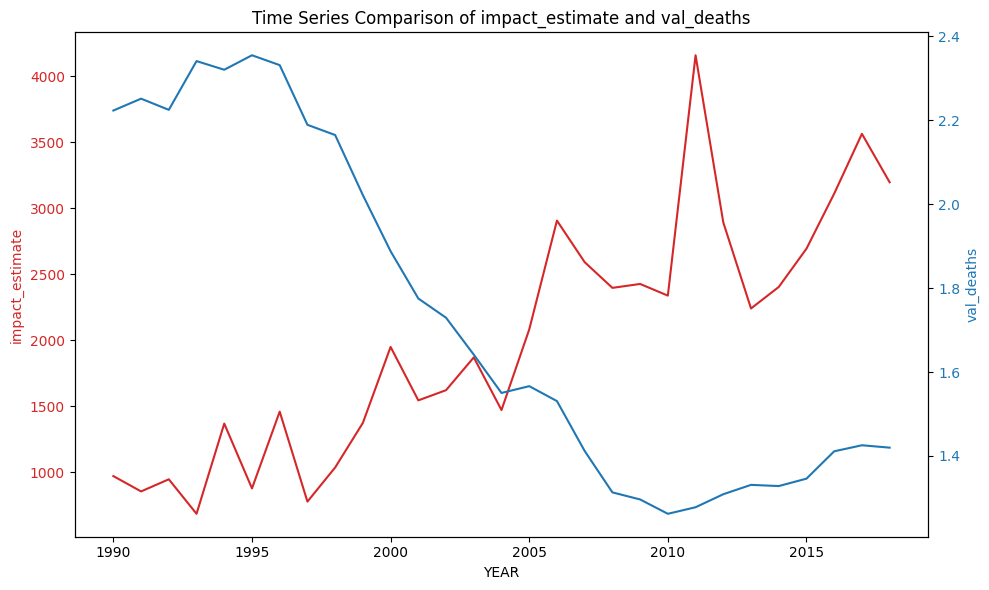

In [11]:
# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# First plot
color = 'tab:red'
ax1.set_xlabel('YEAR')
ax1.set_ylabel('impact_estimate', color=color)
ax1.plot(df_main['YEAR'], df_main['impact_estimate'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('val_deaths', color=color)
ax2.plot(df_main['YEAR'], df_main['val_deaths'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title('Time Series Comparison of impact_estimate and val_deaths')
fig.tight_layout()
plt.savefig('../Results/impact_vs_asthma_deaths.png', bbox_inches='tight')
plt.show()

## Relationship between Smoke Impact Estimate and Asthma Incidents

In [12]:
# Calculate Pearson Correlation
correlation = df_main['impact_estimate'].corr(df_main['val_incidence'])
print(f"Correlation: {correlation}")

Correlation: 0.48023810572257597


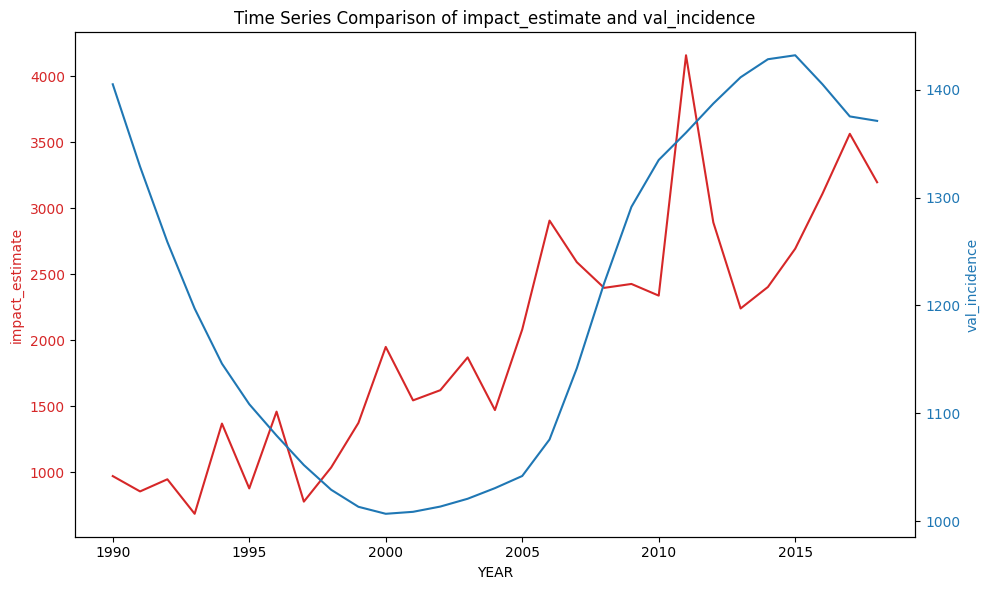

In [13]:
# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# First plot
color = 'tab:red'
ax1.set_xlabel('YEAR')
ax1.set_ylabel('impact_estimate', color=color)
ax1.plot(df_main['YEAR'], df_main['impact_estimate'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('val_incidence', color=color)
ax2.plot(df_main['YEAR'], df_main['val_incidence'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title('Time Series Comparison of impact_estimate and val_incidence')
fig.tight_layout()
plt.savefig('../Results/impact_vs_asthma_incidence.png', bbox_inches='tight')
plt.show()


/Users/vmehrotra/miniconda3/envs/ML/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


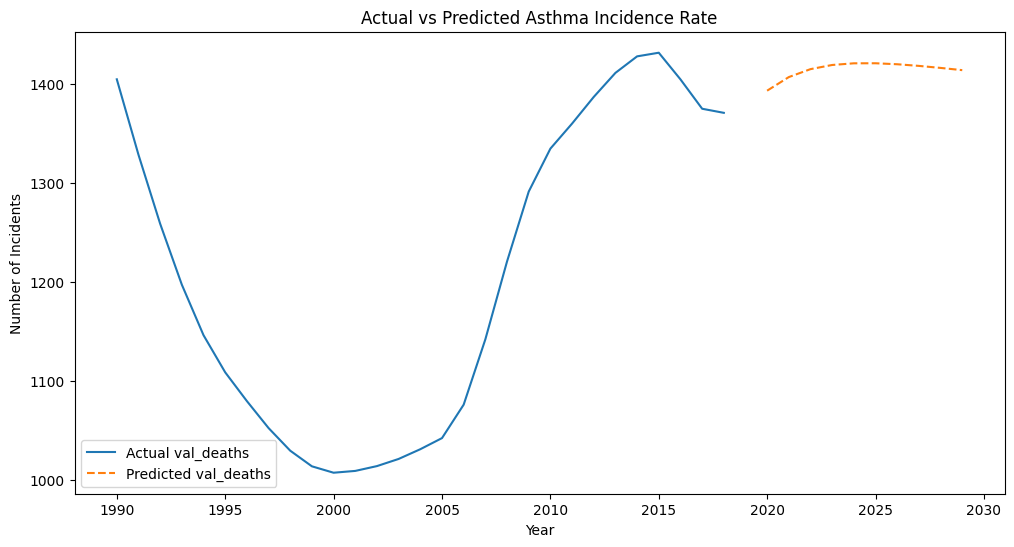

In [14]:
df_main = df_main.reset_index()
df_main['YEAR'] = pd.to_datetime(df_main['YEAR'], format='%Y')
df_main.set_index('YEAR', inplace=True)

# Number of years to predict
steps=10

# Selecting the columns for VAR model
model_data = df_main[['val_incidence', 'impact_estimate']]

# Fitting a VAR model
model = VAR(model_data)
model_fitted = model.fit(maxlags=1, ic='aic')

# Predicting for the next 10 years (10 steps)
# Note: VAR models require specifying the number of steps to predict, which here is steps
forecast = model_fitted.forecast(model_data.values[-model_fitted.k_ar:], steps=steps)

# Creating a new DataFrame for the forecasted values
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=model_data.index[-1], periods=steps+1, freq='Y')[1:],
                           columns=['val_incidence_pred', 'impact_estimate_pred'])

# Plotting the actual and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(model_data['val_incidence'], label='Actual val_deaths')
plt.plot(forecast_df['val_incidence_pred'], label='Predicted val_deaths', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.title('Actual vs Predicted Asthma Incidence Rate')
plt.savefig('../Results/predicted_incidence_rate.png', bbox_inches='tight')
plt.legend()
plt.show()

## Relationship between Smoke Impact Estimate and Women with birth rate

In [15]:
# Calculate Pearson Correlation

correlation = df_main['impact_estimate'].corr(df_main['S1301_C04_001E'])
print(f"Correlation: {correlation}")

Correlation: 0.10701619733226499


In [16]:
# Check metadata
header_mapper['S1301_C04_001E']

'Women with births in the past 12 months!!Rate per 1,000 women!!Estimate!!Women 15 to 50 years'

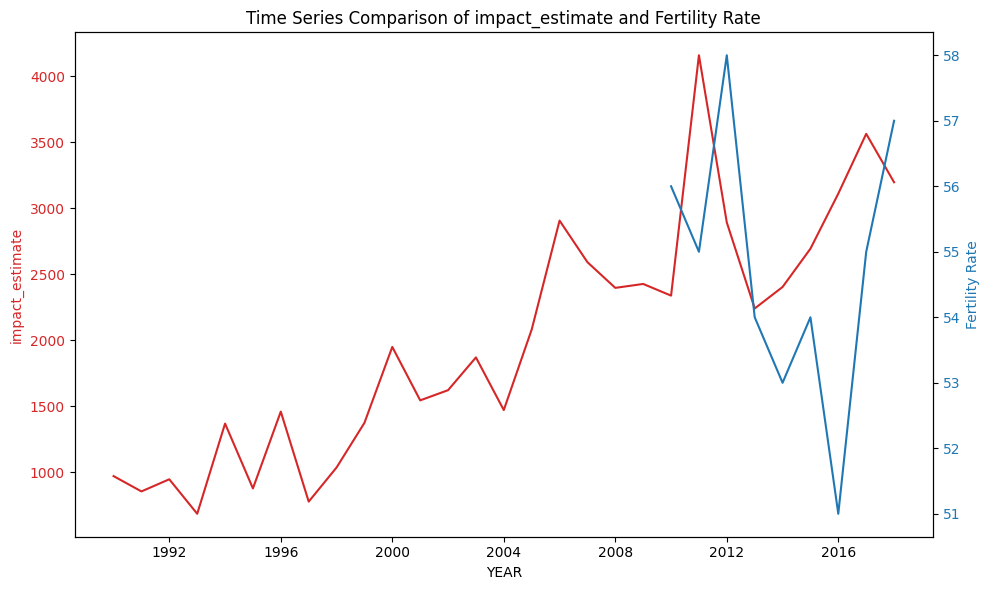

In [17]:
df_main = df_main.reset_index()

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# First plot
color = 'tab:red'
ax1.set_xlabel('YEAR')
ax1.set_ylabel('impact_estimate', color=color)
ax1.plot(df_main['YEAR'], df_main['impact_estimate'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Fertility Rate', color=color)
ax2.plot(df_main['YEAR'], df_main['S1301_C04_001E'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title('Time Series Comparison of impact_estimate and Fertility Rate')
fig.tight_layout()
plt.savefig('../Results/impact_vs_fertility.png', bbox_inches='tight')
plt.show()

## Relationship between Smoke Impact Estimate and Premature Death Rate

In [18]:
# Calculate Pearson correlation
correlation = df_main['impact_estimate'].corr(df_main['CDC20N2U004025'])
print(f"Correlation: {correlation}")

max_lag = 5  # Define maximum lag (in years)
for lag in range(1, max_lag + 1):
    shifted = df_main['CDC20N2U004025'].shift(lag)  # Shift the val_deaths by 'lag' years
    corr = df_main['impact_estimate'].corr(shifted)
    print(f"Correlation with a lag of {lag} year(s): {corr}")

Correlation: 0.42691243487027486
Correlation with a lag of 1 year(s): 0.3669477218818231
Correlation with a lag of 2 year(s): 0.29610797364879177
Correlation with a lag of 3 year(s): 0.3597589208612023
Correlation with a lag of 4 year(s): 0.35051637220850823
Correlation with a lag of 5 year(s): 0.2515470628347882


In [19]:
# Check metadata
header_mapper['CDC20N2U004025']

"The crude death rate is the number of deaths reported each calendar year divided by the population, multiplied by 100,000. Premature death rate includes all deaths where the deceased is younger than 75 years of age. 75 years of age is the standard consideration of a premature death according to the CDC's definition of Years of Potential Life Loss."

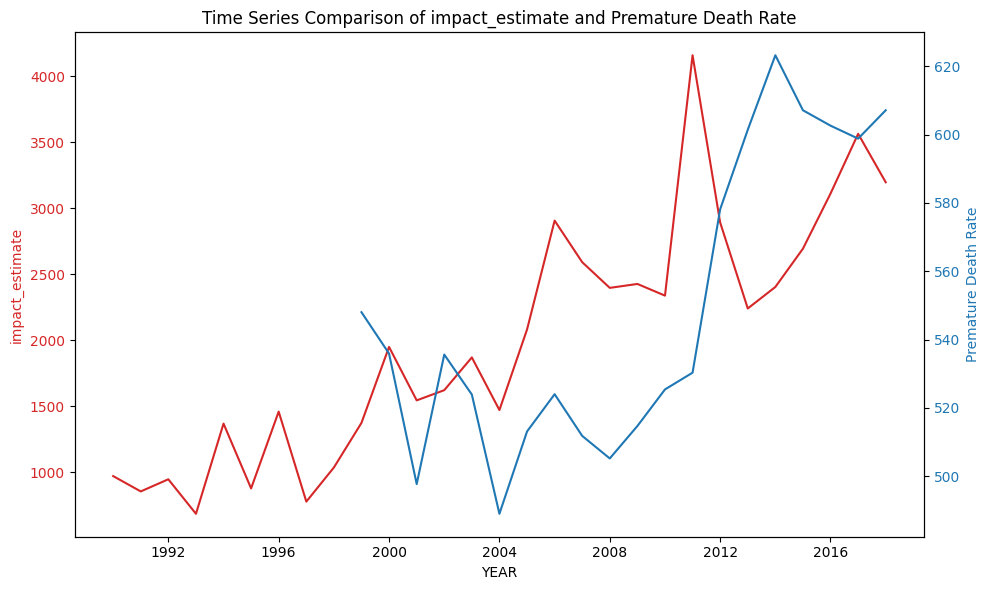

In [20]:
# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# First plot
color = 'tab:red'
ax1.set_xlabel('YEAR')
ax1.set_ylabel('impact_estimate', color=color)
ax1.plot(df_main['YEAR'], df_main['impact_estimate'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Premature Death Rate', color=color)
ax2.plot(df_main['YEAR'], df_main['CDC20N2U004025'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title('Time Series Comparison of impact_estimate and Premature Death Rate')
fig.tight_layout()
plt.savefig('../Results/impact_vs_premature_death.png', bbox_inches='tight')
plt.show()

/Users/vmehrotra/miniconda3/envs/ML/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


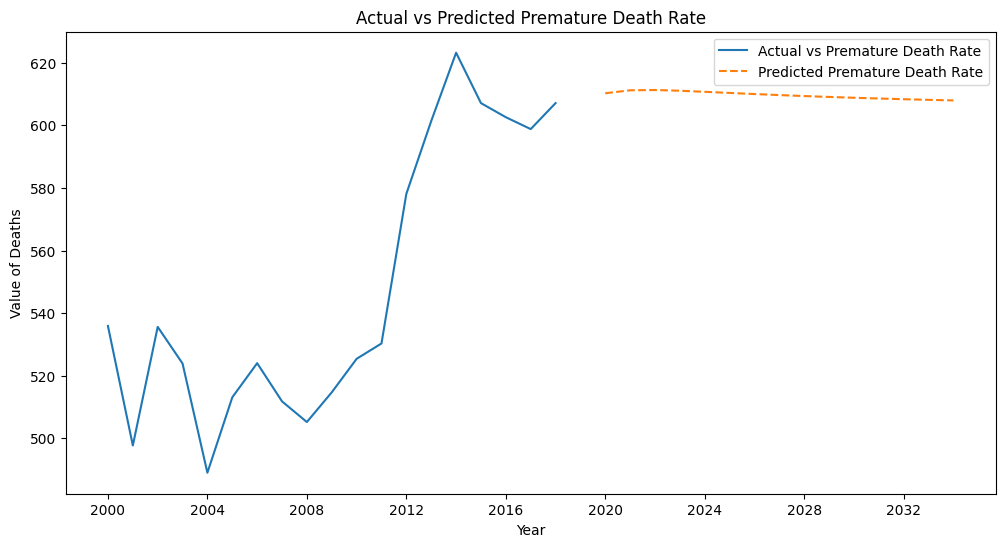

In [21]:
df_main = df_main.reset_index()

df_main['YEAR'] = pd.to_datetime(df_main['YEAR'], format='%Y')
df_main = df_main[df_main.YEAR>pd.to_datetime(1999)]
df_main.set_index('YEAR', inplace=True)

steps=15

# Selecting the columns for VAR model
model_data = df_main[['CDC20N2U004025', 'impact_estimate']]
model_data = model_data[model_data.index > pd.to_datetime('1999-01-01')]

# Fitting a VAR model
model = VAR(model_data)
model_fitted = model.fit(maxlags=3, ic='aic')

# Predicting for the next 10 years (10 steps)
# Note: VAR models require specifying the number of steps to predict, which here is 10 (years)
forecast = model_fitted.forecast(model_data.values[-model_fitted.k_ar:], steps=steps)

# Creating a new DataFrame for the forecasted values
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=model_data.index[-1], periods=steps+1, freq='Y')[1:],
                           columns=['CDC20N2U004025_pred', 'impact_estimate_pred'])

# Plotting the actual and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(model_data['CDC20N2U004025'], label='Actual vs Premature Death Rate')
plt.plot(forecast_df['CDC20N2U004025_pred'], label='Predicted Premature Death Rate', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Value of Deaths')
plt.title('Actual vs Predicted Premature Death Rate')
plt.legend()
plt.savefig('../Results/predicted_premature.png', bbox_inches='tight')
plt.show()

In [22]:
header_mapper

{'GEO_ID': 'Geography',
 'NAME': 'Geographic Area Name',
 'S1301_C01_001E': 'Total!!Estimate!!Women 15 to 50 years',
 'S1301_C01_001M': 'Total!!Margin of Error!!Women 15 to 50 years',
 'S1301_C01_002E': 'Total!!Estimate!!15 to 19 years',
 'S1301_C01_002M': 'Total!!Margin of Error!!15 to 19 years',
 'S1301_C01_003E': 'Total!!Estimate!!20 to 34 years',
 'S1301_C01_003M': 'Total!!Margin of Error!!20 to 34 years',
 'S1301_C01_004E': 'Total!!Estimate!!35 to 50 years',
 'S1301_C01_004M': 'Total!!Margin of Error!!35 to 50 years',
 'S1301_C01_005E': 'Total!!Estimate!!RACE AND HISPANIC OR LATINO ORIGIN!!One race',
 'S1301_C01_005M': 'Total!!Margin of Error!!RACE AND HISPANIC OR LATINO ORIGIN!!One race',
 'S1301_C01_005MA': 'Annotation of Total!!Margin of Error!!RACE AND HISPANIC OR LATINO ORIGIN!!One race',
 'S1301_C01_005EA': 'Annotation of Total!!Estimate!!RACE AND HISPANIC OR LATINO ORIGIN!!One race',
 'S1301_C01_006E': 'Total!!Estimate!!RACE AND HISPANIC OR LATINO ORIGIN!!One race!!White',
